## Alloy optimization

This is a more complex problem than the other problems in the test set. It involves using optimization 
to help the user to select an alloy with an enhanced *X* property after mixing, while the cost of the alloy 
is minimized.

Everything is fictitious. The pure elements have symbols in the A...Z range. The dataset used to obtain the 
*X* property and the cost associated to the pure elements was generated by the *datasetgen.py* script below:
```
# datasetgen.py script

from numpy import random

component=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
x0=0.5
x1=12.6
x=[(x0*k+x1)+random.uniform(0.0,5.0) for k in range(len(component))]
cost=[random.uniform(5.0,500.0) for k in range(len(component))]   

with open("dataset","w") as f:
    f.write("Component,X,Cost\n")
    
    for i in range(len(component)):
        f.write("%s,%f,%f\n" % (component[i],x[i],cost[i]))
```

In [1]:
from mosa import Anneal
from pandas import read_csv
%matplotlib inline

### Defining the population

First, after reading the *dataset* file, the data related to the pure elements are stored into a *pandas* 
dataframe. 

The population is a Python dictionary with two keys. "Component" contains a list of the pure elements. Therefore, 
it represents a **discrete** set of values and the corresponding key in the solutions will contain elements selected from this list. On the other hand, "Concentration" represents the concentration of the alloying element in the alloy and contains an empty list. This defines it as a **continuous** search space. A value in the corresponding key in the solution will be a float randomly chosen within a lower and upper bound defined later.

In [2]:
df=read_csv("dataset")
population={"Component":df.Component.values.tolist(),"Concentration":[]}
print("Components: %s" % (population["Component"]))

Components: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Translating the alloy optimization problem into Python code

A Python function *fobj* implements the problem. A solution is taken as its only argument. The solution also is 
a Python dictionary with the same two keys as the population. In the alloy optimization problem, the first 
element in "Component" is the matrix element, while the second is the alloying element. "Concentration" gives the 
relative amount of the alloying element in the alloy. 

Both the *X* property and the cost of pure elements are loaded from the *pandas* dataframe. Notice that both the *X* 
property and the cost of the alloy results from a simple mixing rule. Also, maximizing *X* is equivalent to minimizing 
-*X*, that is why -*x* is returned by *fobj*.

In [3]:
def fobj(solution):
    elem1=df[df.Component==solution["Component"][0]]
    elem2=df[df.Component==solution["Component"][1]]
    conc=solution["Concentration"][0]
    x1=elem1.X.values[0]
    cost1=elem1.Cost.values[0]
    x2=elem2.X.values[0]
    cost2=elem2.Cost.values[0]  
    x=x1*(1.0-conc)+x2*conc
    cost=cost1*(1.0-conc)+cost2*conc
        
    return [-x,cost]

### Initialization

An *Anneal* object is created with initial definitions. The weights applied to the objectives by calling the *setweight* 
method change the effective, fictitious temperature experienced by the objectives to take into account their magnitudes. 
Moreover, the maximum concentration of the alloying element is 10%, as definded by the *xbounds* dictionary passed as 
one of the arguments to the *setxconfig* method.

In [4]:
opt=Anneal()
opt.setweight([(df.X.values.max()-df.X.values.min()),(df.Cost.values.max()-df.Cost.values.min())])
opt.setarchiveconfig(archivesize=1000,maxarchivereject=10000)
opt.settemp(initemp=1.0,niter=1000,ntemp=100)
opt.setxconfig(xnel={"Component":2,
                     "Concentration":1},
               selweight={"Component":1.0,
                          "Concentration":4.0},
               xdistinct={"Component":True},
               exchangeprob={"Component":1.0,
                             "Concentration":1.0},
               xstep={"Component":5,
                      "Concentration":0.05},
               xbounds={"Concentration":[0.0,0.1]})
opt.setpopulation(population)

--------------------------------------------------
    MULTI-OBJECTIVE SIMULATED ANNEALING (MOSA)    
--------------------------------------------------
Developed by Dr. Roberto Gomes de Aguiar Veiga
Universidade Federal do ABC, Brazil


Setting weights...
Done!
Setting archive configurations...
Done!
Setting temperature...
Done!
Setting solution configurations...
Done!
Setting population...
Done!


### Run

The optimization process actually occurs when the *evolve* method is called with *fobj* as argument.

In [5]:
opt.evolve(fobj)

--- BEGIN: Evolving a solution ---

Initializing archive...
Empty archive!
Done!
Looking for a solution in the checkpoint file...
No checkpoint file!
Done!
------
Population/solution keys:
    ['Component']:
        Number of elements in the population: 26
        (Discrete sampling space)
        Remove from the population the element selected in an MC iteration: True
        Selection weight of this key: 1.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from solution: 0.000000
        Solution sorted after change: False
        Maximum step size to select an element in the population: 5
    ['Concentration']:
        Number of elements in the population: 0
        (Continuous sampling space)
        Boundaries: [0.0000,0.1000]
        Selection weight of this key: 4.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element ins

    Number of accepted moves: 500.
    Fraction of accepted moves: 0.500000.
    No archive update.
------
TEMPERATURE: 0.020276
    Number of accepted moves: 546.
    Fraction of accepted moves: 0.546000.
    Number of archive updates: 1.
    Fraction of archive updates in accepted moves: 0.001832.
------
TEMPERATURE: 0.018248
    Number of accepted moves: 546.
    Fraction of accepted moves: 0.546000.
    No archive update.
------
TEMPERATURE: 0.016423
    Number of accepted moves: 425.
    Fraction of accepted moves: 0.425000.
    No archive update.
------
TEMPERATURE: 0.014781
    Number of accepted moves: 402.
    Fraction of accepted moves: 0.402000.
    No archive update.
------
TEMPERATURE: 0.013303
    Number of accepted moves: 380.
    Fraction of accepted moves: 0.380000.
    No archive update.
------
TEMPERATURE: 0.011973
    Number of accepted moves: 336.
    Fraction of accepted moves: 0.336000.
    No archive update.
------
TEMPERATURE: 0.010775
    Number of accepted mo

    Number of accepted moves: 65.
    Fraction of accepted moves: 0.065000.
    No archive update.
------
TEMPERATURE: 0.000033
    Number of accepted moves: 62.
    Fraction of accepted moves: 0.062000.
    No archive update.
------
TEMPERATURE: 0.000030
    Number of accepted moves: 67.
    Fraction of accepted moves: 0.067000.
    No archive update.
------

--- THE END ---


### Output 1 (all solutions in the archive)

Below we print the content of the archive and plot *X* vs. *Cost*.

In [6]:
opt.printx()

===
Solutions:
1) {'Component': ['I', 'Q'], 'Concentration': [0.06831916940850902]}
2) {'Component': ['E', 'I'], 'Concentration': [0.012421819326918458]}
3) {'Component': ['E', 'I'], 'Concentration': [0.011413559867427314]}
4) {'Component': ['Z', 'X'], 'Concentration': [0.04083130596564905]}
5) {'Component': ['Z', 'X'], 'Concentration': [0.04251043549743619]}
6) {'Component': ['Z', 'X'], 'Concentration': [0.03765684750158222]}
7) {'Component': ['Z', 'X'], 'Concentration': [0.07324119907318893]}
8) {'Component': ['Z', 'X'], 'Concentration': [0.024410161731420132]}
9) {'Component': ['Z', 'X'], 'Concentration': [0.005480785854781234]}
10) {'Component': ['I', 'O'], 'Concentration': [4.767110266225283e-05]}
11) {'Component': ['I', 'D'], 'Concentration': [4.767110266225283e-05]}
12) {'Component': ['Z', 'W'], 'Concentration': [0.0015602016725755619]}
13) {'Component': ['X', 'Z'], 'Concentration': [0.03385617680626396]}
14) {'Component': ['X', 'Z'], 'Concentration': [0.00996164351726253]}
15) 

132) [-17.893264722739627, 28.651056751843292]
133) [-17.753922360568996, 25.135524346574872]
134) [-17.93319088836913, 29.658372308305246]
135) [-18.06953281742319, 33.098205409450806]
136) [-18.22151147193975, 36.932544633640326]
137) [-26.451462313132204, 71.8759198569177]
138) [-27.13034599151463, 75.59543155791083]
139) [-26.969821139244832, 74.71593763968853]
140) [-26.63140813279483, 72.86181862439831]
141) [-26.975841592115685, 74.74892288533736]
142) [-27.370314614414117, 85.62182625564444]
143) [-27.353513383151142, 80.38031465242506]
144) [-27.412352474072737, 98.73645611379644]
145) [-27.38178405353645, 89.1999686727767]
146) [-27.41315975649265, 98.98830552321346]
147) [-27.420762436978777, 101.36012800216545]
148) [-27.35096315727001, 79.58471590507285]
149) [-27.3459322431684, 78.0152122046806]
150) [-26.5163463764214, 72.23141084940582]
151) [-27.302173165753153, 76.53684936699939]
152) [-26.63296615409171, 72.87035481200849]
153) [-26.657027170020946, 73.0021818585797]

951) [-27.257837560138935, 76.29394059027693]
952) [-27.308693916913622, 76.57257567919827]
953) [-26.79861758176471, 73.77793654233378]
954) [-26.703779303352587, 73.2583304632829]
955) [-27.177152133947235, 75.85187607116121]
956) [-27.040886018877117, 75.10529248756433]
957) [-26.919960620434882, 74.44275861206324]
958) [-27.18521272095195, 75.89603893533899]
959) [-27.359106500851805, 82.12521006320243]
960) [-27.417270935325057, 100.27087768805563]
961) [-27.399996388688656, 94.88170500077882]
962) [-27.35337418226199, 80.3368878901687]
963) [-27.35024907727032, 79.36194302935833]
964) [-27.359988850463978, 82.40047832526777]
965) [-27.361406966815505, 82.84289074105381]
966) [-27.390325674930573, 91.86471430640636]
967) [-27.36735449923395, 84.69835357552618]
968) [-27.392187942207965, 92.44568931888945]
969) [-27.348607763988888, 78.8498994490706]
970) [-27.371631048098045, 86.03251653906204]
971) [-27.115939570497545, 75.51650072889137]
972) [-27.220371475431875, 76.08866898794

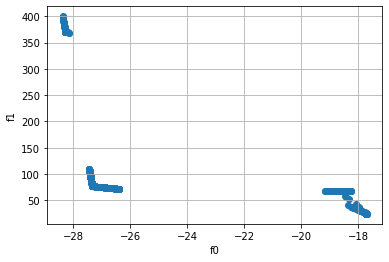

In [7]:
opt.plotfront()

### Output 2 (non-dominated solutions)

Next, we eliminate the dominated solutions, printing only the non-dominated solutions and plotting again *X* vs. *Cost*. As 
you can see, some solutions were removed.

In [8]:
purged=opt.purgedominated()
opt.printx(purged)

===
Solutions:
1) {'Component': ['Z', 'X'], 'Concentration': [0.04083130596564905]}
2) {'Component': ['Z', 'X'], 'Concentration': [0.04251043549743619]}
3) {'Component': ['Z', 'X'], 'Concentration': [0.03765684750158222]}
4) {'Component': ['Z', 'X'], 'Concentration': [0.07324119907318893]}
5) {'Component': ['Z', 'X'], 'Concentration': [0.024410161731420132]}
6) {'Component': ['Z', 'X'], 'Concentration': [0.005480785854781234]}
7) {'Component': ['I', 'O'], 'Concentration': [4.767110266225283e-05]}
8) {'Component': ['I', 'D'], 'Concentration': [4.767110266225283e-05]}
9) {'Component': ['Z', 'W'], 'Concentration': [0.0015602016725755619]}
10) {'Component': ['X', 'Z'], 'Concentration': [0.03385617680626396]}
11) {'Component': ['X', 'Z'], 'Concentration': [0.00996164351726253]}
12) {'Component': ['X', 'Z'], 'Concentration': [0.007201733986366567]}
13) {'Component': ['E', 'X'], 'Concentration': [0.04215808357518245]}
14) {'Component': ['E', 'X'], 'Concentration': [0.023234731360515414]}
15) 

685) {'Component': ['X', 'I'], 'Concentration': [0.07571488274527141]}
686) {'Component': ['X', 'I'], 'Concentration': [0.056797146357695255]}
687) {'Component': ['X', 'I'], 'Concentration': [0.07476471532898055]}
688) {'Component': ['X', 'I'], 'Concentration': [0.06325126264705593]}
689) {'Component': ['X', 'I'], 'Concentration': [0.04570646341375612]}
690) {'Component': ['X', 'I'], 'Concentration': [0.09803004905821416]}
691) {'Component': ['X', 'I'], 'Concentration': [0.006997670067780945]}
692) {'Component': ['X', 'I'], 'Concentration': [0.04972276395846094]}
693) {'Component': ['X', 'I'], 'Concentration': [0.07826408408618886]}
694) {'Component': ['X', 'I'], 'Concentration': [0.07801450798147422]}
695) {'Component': ['X', 'I'], 'Concentration': [0.03178350347702901]}
696) {'Component': ['X', 'Z'], 'Concentration': [0.001280903030936989]}
697) {'Component': ['X', 'Z'], 'Concentration': [0.040436981644877204]}
698) {'Component': ['X', 'Z'], 'Concentration': [0.041480913985356783]}
6

786) [-27.322785109222686, 76.64977941283257]
787) [-27.174464226821833, 75.83714939216969]
788) [-26.993915784874076, 74.84794893883009]
789) [-27.258620720617575, 76.29823142043949]
790) [-27.355738512650447, 81.07449247229462]
791) [-27.421407752821587, 101.56144839499225]
792) [-27.343275120183343, 77.18626456748927]
793) [-27.379598613609275, 88.51817288310288]
794) [-27.352214727755108, 79.97517069479643]
795) [-27.34239863816393, 76.91282682933534]
796) [-27.37088116340317, 85.79857360549104]
797) [-27.350130823735967, 79.32505125263529]
798) [-27.366700138844156, 84.49421153842671]
799) [-27.39684120912859, 93.8973777205057]
800) [-27.38072325040405, 88.86902793157894]
801) [-27.374703625907095, 86.99107439627187]
802) [-27.400970807459995, 95.18569625096904]
803) [-27.44410365480699, 108.64193147031048]
804) [-27.391657933790245, 92.28034159955831]
805) [-27.350976109012176, 79.58875648434932]
806) [-27.38711997640152, 90.86462652870406]
807) [-27.34287483515777, 77.0613868979

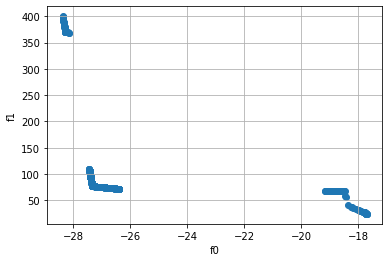

In [9]:
opt.plotfront(purged)

### Decision making

There still are more than 950 solutions (candidate alloys) and it is hard to choose one or two out of them. 

In order to reduce the solution set to something a human being is able to deal with, first, the *trimx* method is 
used to select only the alloys that present a reasonable (according to the users needs) combination of minimum value 
of the *X* property and maximum cost.

In [10]:
trimmed=opt.trimx(xset=purged,thresholds=[-20.0,80])
opt.printx(trimmed)

===
Solutions:
1) {'Component': ['X', 'Z'], 'Concentration': [0.00996164351726253]}
2) {'Component': ['X', 'Z'], 'Concentration': [0.007201733986366567]}
3) {'Component': ['X', 'Z'], 'Concentration': [0.0028168736579362447]}
4) {'Component': ['X', 'Z'], 'Concentration': [0.006095703546321669]}
5) {'Component': ['X', 'Z'], 'Concentration': [0.0017307286781491384]}
6) {'Component': ['X', 'Z'], 'Concentration': [0.0072545546273169725]}
7) {'Component': ['X', 'I'], 'Concentration': [0.09242414119551895]}
8) {'Component': ['X', 'I'], 'Concentration': [0.02195781203123072]}
9) {'Component': ['X', 'I'], 'Concentration': [0.03861986687108862]}
10) {'Component': ['X', 'I'], 'Concentration': [0.0737462413374795]}
11) {'Component': ['X', 'I'], 'Concentration': [0.03799495979609964]}
12) {'Component': ['X', 'Z'], 'Concentration': [0.008747451857076594]}
13) {'Component': ['X', 'Z'], 'Concentration': [0.0038966013271382396]}
14) {'Component': ['X', 'I'], 'Concentration': [0.0856893471404502]}
15) {

205) [-27.273183729333653, 76.37802017224772]
206) [-26.52397382185602, 72.2732005896016]
207) [-26.93612876456226, 74.53134168333166]
208) [-26.85171854774107, 74.06886954097902]
209) [-26.535859605284895, 72.33832118676267]
210) [-26.572465450899426, 72.53887965564854]
211) [-27.05964939969923, 75.20809450908934]
212) [-26.666289726850632, 73.05293015258971]
213) [-26.71432768965769, 73.31612364278885]
214) [-27.31287549246554, 76.59548596514152]
215) [-26.724091888269864, 73.36962036416438]
216) [-26.43924712385161, 71.80899448972188]
217) [-26.734382249902524, 73.42599986144633]
218) [-27.270970039151237, 76.3658916636415]
219) [-26.55469705856051, 72.44152904122534]
220) [-27.07805153457862, 75.30891731303453]
221) [-27.33764051588613, 76.73117017338132]
222) [-26.723262779496483, 73.36507778951987]
223) [-26.867088884283326, 74.15308153257283]
224) [-26.707635271902788, 73.27945679257587]
225) [-27.002956530410884, 74.89748195881666]
226) [-27.163875293542098, 75.77913406128292]


Only alloys with X element as the matrix element remained, but we are still talking about more than 500! The next step 
is to reduce much more the number of solutions. In the line below, we use the *reducex* method to select 10 alloying 
candidates with the lowest cost, assuming the cost is the variable that counts the most for the user.

In [11]:
sol1=opt.reducex(xset=trimmed,index=1,nel=10)
opt.printx(sol1)

===
Solutions:
1) {'Component': ['X', 'I'], 'Concentration': [0.09983897275714411]}
2) {'Component': ['X', 'I'], 'Concentration': [0.09974995310373233]}
3) {'Component': ['X', 'I'], 'Concentration': [0.09890514249254324]}
4) {'Component': ['X', 'I'], 'Concentration': [0.09873104166449669]}
5) {'Component': ['X', 'I'], 'Concentration': [0.09825044473398631]}
6) {'Component': ['X', 'I'], 'Concentration': [0.09810960231588473]}
7) {'Component': ['X', 'I'], 'Concentration': [0.09803004905821416]}
8) {'Component': ['X', 'I'], 'Concentration': [0.09791963057153168]}
9) {'Component': ['X', 'I'], 'Concentration': [0.09760307727750883]}
10) {'Component': ['X', 'I'], 'Concentration': [0.09702768103330814]}
Values:
1) [-26.380026661738945, 71.48453360079446]
2) [-26.380884291056002, 71.4892324356339]
3) [-26.389023329119468, 71.53382512253425]
4) [-26.390700643830698, 71.54301490260016]
5) [-26.39533079011295, 71.5683828468041]
6) [-26.3966876880812, 71.57581710694419]
7) [-26.397454116655457, 71

Interestingly, the alloys with lowest cost are those with I element as alloying element in an X element matrix. To 
reduce the number of candidates even further, we use the *reducex* method again, but now to select 5 alloy candidates 
with the highest value of the *X* property (or, conversely, the lowest value of -*X*).

In [12]:
sol2=opt.reducex(xset=sol1,index=0,nel=5)
opt.printx(sol2)

===
Solutions:
1) {'Component': ['X', 'I'], 'Concentration': [0.09702768103330814]}
2) {'Component': ['X', 'I'], 'Concentration': [0.09760307727750883]}
3) {'Component': ['X', 'I'], 'Concentration': [0.09791963057153168]}
4) {'Component': ['X', 'I'], 'Concentration': [0.09803004905821416]}
5) {'Component': ['X', 'I'], 'Concentration': [0.09810960231588473]}
Values:
1) [-26.407111087579185, 71.63292550066673]
2) [-26.401567629825344, 71.60255364664235]
3) [-26.398517905691865, 71.58584462128131]
4) [-26.397454116655457, 71.58001626526939]
5) [-26.3966876880812, 71.57581710694419]
